# EXPERIMENTO - ENFOQUES AVANZADOS: FINE-TUNING BERT (CON BETO)
Se realiza la experimentación sobre enfoques de transformers, haciendo uso de *BETO* (BERT pre-entrenado sobre corpus en español-latino).

Primero se carga el dataset a estudiar (ubicación especificada en "Configuraciones para la Ejecución"). Se procede a formatear las sentencias para hacer uso de BERT. Luego se preparan los datos y se aplica el proceso de *Fine-Tuning BERT* a través de PyTorch.


## Librerías necesarias

In [ ]:
#importing a few necessary packages and setting the DATA directory
DATA_DIR="."
import os
import numpy as np
import pickle
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore") 

#Bert con libreria transformers
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig

# BERT imports para iteradores, pad&trunc, split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
#Optimyzer y LR scheduler
from transformers import get_linear_schedule_with_warmup

#Codificación de etiquetas
from sklearn.preprocessing import LabelEncoder

#Evaluación y reportes
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#Curva de Aprendizaje
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

#Otras librerias utiles
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import unicodedata
import time
import datetime

# Espificicación GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)
print("Nombre - Device:", torch.cuda.get_device_name(0))
#print("Cantidad de núcleos asignados:", n_gpu)

Nombre - Device: Tesla T4


REPRODUCIBILIDAD EN PyTORCH

In [ ]:
#REPRODUCIBILITY IN PyTorch
import random

#Setear valor Seed para hacer los resultados reproducibles
#    Esto es importante: Trabajamos con un dataset muy chico => Los valores de Accuracy pueden ser cambiar significativamente
seed_val = 2020

random.seed(seed_val)
np.random.seed(seed_val) #Semilla para bibliotecas usadas (Ej: algunas biblitecas usan numpy random generator)
torch.manual_seed(seed_val) 
torch.cuda.manual_seed_all(seed_val)#Semilla para pytorch (para cuda, cpu, etc)
torch.backends.cudnn.deterministic = True #Uso de Algoritmos deterministas: Dada una entrada siempre la misma salida
torch.backends.cudnn.benchmark = False #Funciones de evaluación se adaptan para obtener resultados reproducibles
os.environ['PYTHONHASHSEED'] = str(seed_val)

## Configuraciones para la Ejecución
Setear siguientes las configuraciones:

1. Dataset a utilizar: Ubicación y/o nombre de cada archivo<br>
Para usar dataset 1 (DS1) colocar flag en True, en otro caso, se aplica el estudio sobre el dataset 2 (DS2)

2. Setear Modelo a utilizar: <br>
Se trabajará con BETO (BERT en español)

3. Setear Learning Rate (LR)<br>
LR: Rapidez del Algoritmo de Aprendizaje, será utilizado al definir el optimizador

4. Setear otros parámetros<br>
VALID_SIZE: tamaño de Conjunto de Validación<br>
BATCH_SIZE: tamaño de lotes de muestras para el entrenamiento<br>
EPOCHS: Cantidad de épocas para el proceso Fine-Tuning<br>

5. Almacenamiento de Resultados y Reportes<br>
Setear nombres de archivos para el almacenamiento de los resultados finales

In [ ]:
#CONFIGURACIONES PARA LA EJECUCIÓN

#--------------------------------------------------------------
#1. Dataset a utilizar: Ubicación y/o nombre de cada archivo
#--------------------------------------------------------------

#DS1 = Consultas Usuario + Extensiones + Consultas AFIP (Integración Total)
#   >> Setear DS_select = True
#DS2 = Consultas Usuario + Extensiones | Test: Consultas AFIP
#   >> Setear DS_select = False
DS1_select = True
if DS1_select: 
  #Será dividido en 80/20 para training/test
  DS_NAME = "DS1_usuario_afip.csv"
  TEST_NAME = None
else:
  DS_NAME = "DS2-train_usuario.csv"
  TEST_NAME = "DS2-test_afip.csv"

#--------------------------------------------------------------
#2. Setear modelo a utilizar: BETO
#--------------------------------------------------------------

# BERT multilenguaje (con mayus) -> bert-base-multilingual-cased            
# BERT multilenguaje (sin mayus) -> bert-base-multilingual-uncased          
# BETO (con mayus) -> dccuchile/bert-base-spanish-wwm-cased"                         
# BETO (sin mayus) -> dccuchile/bert-base-spanish-wwm-uncased"
# Más detalles sobre BETO: https://github.com/dccuchile/beto
#----------------------------------------------------------------
# Comparación de Modelos con LR: 2e-5
#                     Acc-Prom
# BERTmulti cased   ==> 78%
# BERTmulti uncased ==> 74,5%
# BETO cased        ==> 81,8%
# BETO uncased      ==> 84%   [EL MEJOR MODELO]
#----------------------------------------------------------------

MODEL_select = 'dccuchile/bert-base-spanish-wwm-uncased'

#------------------------------------------------------------------
#3. Setear Learning Rate (LR) - Autores sugieren: 5e-5, 3e-5, 2e-5 
#------------------------------------------------------------------

#----------------------------------------------------------------
#Resultados Obtenidos variando LR (Promedio de 10 ejecuciones)
#                      (DS1)  | (DS2)
# LR=2e-5 ==> Acc-Prom  84%   | 88,5%
# LR=3e-5 ==> Acc-Prom  86%   | 91,2%
# LR=5e-5 ==> Acc-Prom  87,8% | 93,6%     [EL MEJOR]
#Resultados Obtenidos variando LR  (Device=Tesla T4 / seed_val=2020) 
#                      (DS1)   | (DS2)
# LR=2e-5 ==> Acc-Prom  83%    | 88,9%
# LR=3e-5 ==> Acc-Prom  85,9%  | 92%
# LR=5e-5 ==> Acc-Prom  88,4%  | 93,2%     [EL MEJOR]
#----------------------------------------------------------------
#Setear LR
LR = 5e-5  

#------------------------------------------------------------------
#4. Setear otros parámetros
#------------------------------------------------------------------

#4. SETEAR VALID_SIZE(split Train/Validation), BATCH_SIZE y EPOCHS
VALID_SIZE = 0.1
BATCH_SIZE = 32
EPOCHS = 4


#------------------------------------------------------------------
#5. Almacenamiento de Resultados y Reportes
#------------------------------------------------------------------
DF_RESULTADOS = pd.DataFrame(columns=["device", "data", "lossTrain", "accValid", "accTestFinal"])
DETALLE = ""
if MODEL_select=='dccuchile/bert-base-spanish-wwm-uncased':
  DETALLE = "BETOuncased-"
elif MODEL_select=='dccuchile/bert-base-spanish-wwm-cased':
  DETALLE = "BETOcased-"
elif MODEL_select=='bert-base-multilingual-uncased':
  DETALLE = "multiBERTuncased-"
elif MODEL_select=='bert-base-multilingual-cased':
  DETALLE = "multiBERTcased-"
DETALLE = DETALLE + "LR"+str(LR)+"-"

FILE_NAME_RES = "Resultado_" +DETALLE+ "_procTest.csv"

#REGISTRO DE PREGUNTAS MAL CLASIFICADAS
DF_MAL_CLF =  pd.DataFrame(columns=["DS", "MOD", "Texto", "Predicho","Real"])
FILE_NAME_CLF = "PregMalClasif_BERT.csv"

## Carga de Datos y Preprocesamiento
La función *load_dataset(..)* genera el dataset a evaluar guardando los datos en df_train y df_test. Luego realiza el preprocesamiento de los datos considerando, en particular, corrección de palabras, eliminación de repetición de simbolos, entre otros.

In [ ]:
correccion_palabras = { 'aherir' : 'adherir', 'aniticipo' : 'anticipo', 'baje' : 'baja','caracterísiticas' : 'caracteristicas','caragas' : 'cargas',
                        'caratacterísticas' : 'caracteristicas','condiminios' : 'condominios','constribuyentes' : 'contribuyentes','deden' : 'deben',
                        'incripto' : 'inscripto','infromé' : 'informe','inregular' : 'irregular','inscriibirme' : 'inscribirme','monostributista' : 'monotributista',
                        'monotribustistas' : 'monotributistas','monotributisa' : 'monotributista','monotributistas' : 'monotributistas',
                        'opraciones' : 'operaciones','parámentros' : 'parametros','permanezo' : 'permanezco','porciento' : 'por ciento',
                        'porqué' : 'por que','previsioanl' : 'previsional','qié' : 'que','registo' : 'registro','reitegren' : 'reintegren',
                        'requisistos' : 'requisitos','resposable' : 'responsable','semetre' : 'semestre','siginifica' : 'significa',
                        'situadios' : 'situados','solitar' : 'solicitar','trancurrir' : 'transcurrir' }

def preprocesamiento(texto):
    texto = re.sub(r'[^\w ¿?%/()]', "", texto)   #Eliminar TODO menos: \w = alphanum y ¿?%/
    if MODEL_select.rfind('uncased')>-1: #Conversión a minúsculas si uso un modelo con vocabulario minusculas
      texto = texto.lower()  #Texto a minúscula
    #Reescritura de palabras mal escritas
    texto = ''.join(correccion_palabras[w] if w in correccion_palabras else w for w in re.split(r'(\W+)', texto)) 
    #Eliminar acentos ==> VER SI NO LO HAGO PORQUE BERT/BETO TIENE ACENTOS
    texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn') 
    #Remover letras con 2 ocurrencias (con excepciones)      
    letras_dobles = "abdfghijkmnñpqstuvwxyz" # Excepciones: ee-cc-ll-rr-oo (y mayus)
    letras_dobles += letras_dobles.upper()          
    texto = re.sub("(?P<char>[" + re.escape(letras_dobles) + "])(?P=char)+", r"\1", texto) 
    #remover caracteres que se repiten al menos 3 veces
    texto = re.sub(r'([\w\W])\1{2,}', r'\1', texto) 
    #remover palabras que se repiten 
    texto = re.sub(r'\b(\w+)(\b\W+\b\1\b)*', r'\1', texto) 
    #Eliminar repetición de espacios
    texto = re.sub(r"\s{2,}", " ", texto) 
    return texto

def procesar_sentencias(sentencias):
    sentencias_limpias = []
    for s in sentencias:
        clean = preprocesamiento(s)
        sentencias_limpias.append(clean)
    return sentencias_limpias

def load_dataset(filename):
  #df = pd.read_csv("DS1_usuario_afip.csv",engine='python', error_bad_lines=False)
  df = pd.read_csv(filename, encoding = "utf-8", names = ["IUCA","Texto", "Etiqueta"], header=0)
  print("Carga Dataset:\n", df.head())
  print("Cantidad de Sentencias:", df.shape[0])
  #df["Texto"] = procesar_sentencias(df["Texto"])
  #print(df.head())
  sentencias = list(df["Texto"])
  etiquetas = list(df["Etiqueta"])
  return sentencias, etiquetas

if DS1_select: 
  X,Y = load_dataset(DS_NAME)
  sent_train, sent_test, etiq_train, etiq_test = train_test_split(X, Y, test_size = 0.20, random_state=0)  
else:
  sent_train, etiq_train = load_dataset(DS_NAME)
  sent_test, etiq_test = load_dataset(TEST_NAME)
print("\nCONJUNTO TRAINING: Preprocesamiento")
print("Datos a procesar:")
print(*(sent_train[:5]), sep="\n", end="\n...\n")
sent_train = procesar_sentencias(sent_train)
print("Datos procesados:")
print(*(sent_train[:5]), sep="\n", end="\n...\n")


print("\nCONJUNTO TEST: Preprocesamiento")
print("Datos a procesar:")
print(*(sent_test[:5]), sep="\n", end="\n...\n")
sent_test = procesar_sentencias(sent_test)
print("Datos procesados:")
print(*(sent_test[:5]), sep="\n", end="\n...\n")

#Guardamos los Conjuntos TRAINING (df_train) y TEST (df_test)
df_train = pd.DataFrame(columns=["Texto", "Etiqueta"])
df_train['Texto'] = sent_train
df_train['Etiqueta'] = etiq_train
df_test = pd.DataFrame(columns=["Texto", "Etiqueta"])
df_test['Texto'] = sent_test
df_test['Etiqueta'] = etiq_test
print("\nCONJUNTO TRAINING CREADO:\n",df_train.head())
print("\nCONJUNTO TEST CREADO:\n",df_test.head())
#print(">>Hay muestras de todas las clases en Test? -> ", len(np.unique(df_test['Etiqueta']))==10)


print('\n>>TRAINING SET: {} - TESTING SET: {}'.format(df_train.shape[0],df_test.shape[0]))

Carga Dataset:
    IUCA                                              Texto Etiqueta
0     0  ¿Puedo darme de baje por el tiempo en que no r...    si_no
1     0  Si dejo de trabajar por un tiempo, ¿puedo darm...    si_no
2     0  ¿Puedo dar de baja mi monotributo y transcurri...    si_no
3     0  ¿Es obligatorio seguir inscripto en el régimen...    si_no
4     0  ¿Qué sucede si me doy de baja y luego retomo m...   manera
Cantidad de Sentencias: 1385

CONJUNTO TRAINING: Preprocesamiento
Datos a procesar:
¿De dónde puedo sacar la credencial de pago?
¿Si una sociedad con fines de lucro quiere sumarse al monotributo, puede?
Si soy Monotributista ¿Debo mostrarlo en mi negocio?
Si realizo actividades para las que debo pagar Impuesto a las Ganancias y para otras Monotributo ¿Qué pasa cuando adiciono otra actividad al Monotributo?
¿A qué se refiere el concepto de  recategorización?
...
Datos procesados:
¿de donde puedo sacar la credencial de pago?
¿si una sociedad con fines de lucro quiere suma

##Codificación de Etiquetas
Mapeo de etiquetas a números entre 0 y #clases-1. También se muestra la frecuencia de cada clase, para los conjuntos train y test.

In [ ]:
#from sklearn.preprocessing import LabelEncoder
#Convertir Nombres de Etiquetas a Número=> 0-10

print("Conversión de Etiquetas")
le = LabelEncoder()
print("\nCONJUNTO TRAINING")
etiq_codif = le.fit_transform(df_train["Etiqueta"])
print("Index - Etiqueta    Frecuencia")
for i,c in enumerate(le.classes_):
  etiq_frec = ((df_train[df_train['Etiqueta']==c]['Etiqueta']).value_counts()).to_string()
  print("",i,"-",etiq_frec)
df_train['Etiqueta'] = etiq_codif

print("\nCONJUNTO TEST")
etiq_codif = le.fit_transform(df_test["Etiqueta"])
print("Index - Etiqueta    Frecuencia")
for i,c in enumerate(le.classes_):
  etiq_frec = ((df_test[df_test['Etiqueta']==c]['Etiqueta']).value_counts()).to_string()
  print("",i,"-",etiq_frec)
df_test['Etiqueta'] = etiq_codif


#Decodificar etiquetas
def revertir_etiquetas(etiquetas):
  return le.inverse_transform(etiquetas)

Conversión de Etiquetas

CONJUNTO TRAINING
Index - Etiqueta    Frecuencia
 0 - cantidad    5
 1 - definicion    31
 2 - entidad    2
 3 - manera    237
 4 - procedimiento    148
 5 - razon    80
 6 - referencia    74
 7 - si_no    430
 8 - temporal    94
 9 - ubicacion    7

CONJUNTO TEST
Index - Etiqueta    Frecuencia
 0 - cantidad    2
 1 - definicion    9
 2 - entidad    2
 3 - manera    63
 4 - procedimiento    42
 5 - razon    16
 6 - referencia    11
 7 - si_no    109
 8 - temporal    21
 9 - ubicacion    2


##FORMATO BERT
Se aplican todas las modificaciones necesarias para la ejecución de sentencias sobre BERT

#### 1*.* Agregar tokens especiales: [CLS] y [SEP]

In [ ]:
#BERT trabaja con un formato específico en los datos de entrada:
# Inicio de sentencia: token [CLS] (indicamos a BERT que estamos en una Tarea de Clasificación)
# Fin de sentencia: token [SEP]
print("CONJUNTO TRAINING: Formatear sentencias\n")
sentencias = df_train['Texto']
sentencias_formato = ["[CLS] "+i+" [SEP]" for i in sentencias]
print(">>Cantidad de sentencias formateadas:",len(sentencias_formato))
print("\n1° sentencia formateada:", sentencias_formato[0])

CONJUNTO TRAINING: Formatear sentencias

>>Cantidad de sentencias formateadas: 1108

1° sentencia formateada: [CLS] ¿de donde puedo sacar la credencial de pago? [SEP]


####2*.* Tokenizar sentencias con BertTokenizer

In [ ]:
#from transformers import BertTokenizer

print("CONJUNTO TRAINING: Tokenizar sentencias para BERT\n")
#Tokenizar sentencias en tokens usando el Vocabulario de BERT
#Cargamos BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_select, do_lower_case=True)
#tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)
print("Algunos tokens interesantes:")
print("        0-5: ",list(tokenizer.vocab.keys())[0:5])
print("    100-105: ",list(tokenizer.vocab.keys())[100:105])
print("12010-12020: ",list(tokenizer.vocab.keys())[10000:10100])
#print("vocabulario tokenizer: ", tokenizer.vocab)

# Restringir la máxima cantidad de tokens/Embeddings por sentencia a 512 (Máximo permitido en BERT)
tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:510], sentencias_formato))
print("\n>>Cantidad de sentencias tokenizadas:",len(tokenized_texts))
print("\n1° sentencia tokenizada:", tokenized_texts[0])


CONJUNTO TRAINING: Tokenizar sentencias para BERT

Algunos tokens interesantes:
        0-5:  ['[MASK]', '[PAD]', '[EOS]', '[UNK]', '[CLS]']
    100-105:  ['[unused94]', '[unused95]', '[unused96]', '[unused97]', '[unused98]']
12010-12020:  ['##ércoles', '##king', 'querría', 'logros', 'cifra', 'disfra', '##mago', '##politan', 'jueces', 'relev', 'miércoles', 'acerc', '##tuario', '##vias', 'ino', 'tenéis', 'pete', 'mami', 'formulación', 'trono', '##abeth', 'ecol', 'campañas', 'apropiado', 'oyes', 'vera', 'perdone', 'ordenó', '##teme', 'regal', 'depósito', 'guad', 'planos', 'directora', 'integridad', 'alien', 'eco', 'pudieran', '##uración', 'integrada', '##rás', 'inspección', 'sebas', 'fama', 'altitud', 'entradas', 'agenda', 'koso', 'steph', '##pé', 'cemen', 'japonés', 'cuantos', 'incidente', 'despedir', 'cincu', 'mens', '##burg', 'granja', 'sufrido', 'lidera', 'leído', 'nosotras', '##tamo', '##hua', 'rean', 'dormido', 'compi', 'ina', '##pula', 'agrup', 'perspectivas', 'atm', 'canales', 'a

In [ ]:
#Guardamos las Etiquetas Codificadas
labels = list(df_train['Etiqueta'])
print(">>Cantidad de Etiquetas Codificadas guardadas :",len(labels))

>>Cantidad de Etiquetas Codificadas guardadas : 1108


####3*.* Codificar tokens de BERT y Padding de sentencias

In [ ]:
#Buscar MAX_LEN de tokens por sentencia (para padding y truncate)
print('>>Longitud Máxima de todas las Sentencias:', max([len(sen) for sen in tokenized_texts]))

>>Longitud Máxima de todas las Sentencias: 73


In [ ]:
#from keras.preprocessing.sequence import pad_sequences
# Setear la máxima longitud de sentencia
MAX_LEN = 96 

#TOKENS A ÍNDICES DE BERT
# Usar tokenizador de BERT para convertir los tokens en índices del vocabulario de BERT
print("Tokens a Índices: tks->id")
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
print(">>OK!")
#PADDING Y TRUNCATING de Sentencias
#relleno y truncado al final con 0s
print("Padding y Truncating")
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
print(">>OK!")

print("\nCantidad de sentencias modificadas (índices + pad_trunc):", len(input_ids))
print("\n1° sentencia tokenizada:\n", input_ids[0])

Tokens a Indices: tks->id
>>OK!
Padding y Truncating
>>OK!

Cantidad de sentencias modificadas (indices + pad_trunc): 1108

1° sentencia tokenizada:
 [    4  1063  1009  1655  1555  4864  1032 18926  1627  1009  5041  1059
     5     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]


####4*.* Crear Máscaras de Atención

In [ ]:
# Crear attention masks:
# 1: token real | 0: token padding
print("Máscaras de Atención: tks reales(1) vs tks ficticios(0)")
attention_masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

print("\nMáscaras de Atencion:", len(attention_masks))
print("\nMáscara de Atención asociada a la 1° sentencia:\n", attention_masks[0])


Máscaras de Atención: tks reales(1) vs tks ficticios(0)

Máscaras de Atencion: 1108

Máscara de Atención asociada a la 1° sentencia:
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## FINE-TUNING BERT

###1*.*  Preparar Datos
- División: Training/Validation
- Conversión: Training/Validation a Tensor Torch
- Crear Iterador de Datos (DataLoader)

In [ ]:
#from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#from sklearn.model_selection import train_test_split
#Realizaremos las siguientes tareas:
# 1. DIVISIÓN: Training/Validation
# 2. CONVERSIÓN: Conj. Training/Validation a Tensor Torch
# 3. ITERADOR DE DATOS: DataLoader
#Setear batch_size para DataLoader
batch_size = 32


# 1. DIVISIÓN: Training/Validation
print("División: Training/Validation")
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=0, test_size=VALID_SIZE)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=0, test_size=0.10)
print('>>Cantidad de Muestras: Training: {} | Validation: {}'.format(len(train_inputs) ,len(validation_inputs)))

# 2. CONVERSIÓN: Conj. Training/Validation a Tensor Torch
#     Tensor Torch: Tipo de dato requerido por el modelo BERT
print("\nConversión: Training/Validation a Tensor Torch")
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
print('>>Cantidad de datos modificados: Training: {} | Validation: {}'.format(len(train_inputs),len(validation_inputs)))


# 3. ITERADOR DE DATOS: DataLoader

print("\nIterador de Datos (DataLoader)")
# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

print("DataLoader - Training:")
tamDL = len(train_dataloader)
print("Cantidad de Batches:", tamDL)
for i, batch in enumerate(train_dataloader):
  if (i<=3 or i >tamDL-4 ):
    if (i<3 or i >tamDL-4 ):
      print("Batch",i+1,"de",tamDL," - Cantidad de Sentencias:", len(batch[0]))
    elif i==3 and i<tamDL: 
      print("...")
  
print("\nDataLoader - Validation:")
tamDL = len(validation_dataloader)
print("Cantidad de Batches:", tamDL)
for i, batch in enumerate(validation_dataloader):
  if (i<=3 or i >tamDL-4 ):
    if (i<3 or i >tamDL-4 ):
      print("Batch",i+1,"de",tamDL," - Cantidad de Sentencias:", len(batch[0]))
    elif i==3: 
      print("...")

División: Training/Validation
>>Cantidad de Muestras: Training: 997 | Validation: 111

Conversión: Training/Validation a Tensor Torch
>>Cantidad de datos modificados: Training: 997 | Validation: 111

Iterador de Datos (DataLoader)
DataLoader - Training:
Cantidad de Batches: 32
Batch 1 de 32  - Cantidad de Sentencias: 32
Batch 2 de 32  - Cantidad de Sentencias: 32
Batch 3 de 32  - Cantidad de Sentencias: 32
...
Batch 30 de 32  - Cantidad de Sentencias: 32
Batch 31 de 32  - Cantidad de Sentencias: 32
Batch 32 de 32  - Cantidad de Sentencias: 5

DataLoader - Validation:
Cantidad de Batches: 4
Batch 1 de 4  - Cantidad de Sentencias: 32
Batch 2 de 4  - Cantidad de Sentencias: 32
Batch 3 de 4  - Cantidad de Sentencias: 32
Batch 4 de 4  - Cantidad de Sentencias: 15


###2*.*  Cargar Modelo BERT desde Sitio Web

In [ ]:

#from transformers import BertForSequenceClassification, AdamW, BertConfig

#CARGA DEL MODELO BERT

#Cargamos BertForSequenceClassification (modelo preentrenado de BERT) 
#   Capa final: Clasificación Lineal
print("Carga: Modelo de BERT:", MODEL_select)
n_clases = len(np.unique(labels))
#model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased", num_labels=n_clases, #10 clases para Clasificacion
model = BertForSequenceClassification.from_pretrained( MODEL_select, num_labels=n_clases, #10 clases para Clasificacion
      output_attentions = False, # Modelo no devuelva los pesos de Attentions.
      output_hidden_states = False # Modelo no devuelva todos los estados ocultos
     )
print(">>OK!")
#Le decimos a pytorch que ejecute el modelo sobre la GPU
print("\nEjecución del Modelo sobre GPU (pytorch)\n")
model.cuda()

Carga: Modelo de BERT: dccuchile/bert-base-spanish-wwm-uncased


Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncas

>>OK!

Ejecución del Modelo sobre GPU (pytorch)



BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Ver algunos parámetros de las capas del Modelo de BERT

In [ ]:
#Parámetros de algunas capas del Modelo de BERT

params = list(model.named_parameters())
print('MODELO DE BERT - Cantidad de parámetros nombrados diferentes: {:}\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Primer Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

MODELO DE BERT - Cantidad de parámetros nombrados diferentes: 201

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (31002, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== Primer Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bia

###3*.* Setear Optimizador, Scheduler LR y otras funciones necesarias

In [ ]:
#---------------------------------------------------------------------------------------------------------- 
#Optimizador AdamW - Tutorial McCormick
#---------------------------------------------------------------------------------------------------------- 
#Definición del optimizador AdamW para BERT (AdamW: Clase de la librería de HuggingFace - Extraída de transformers)

#Para Fine-Tuning los autores recomiendan setear los parámetros considerando:
#EPOCHS = 2, 3, 4 (Elegimos 4)
#BATCH_SIZE = 16 o 32 
#Learning Rate (Adam) = 5e-5, 3e-5, 2e-5 (Elegimos 2e-5)
#Epsilon eps = 1e-8 => Valor "más chico" que permite prevenir dvisiones por 0 en la implementación
#Nota: AdamW: "W" puede venir de "Weight Decay Fix"-Corrección de Caída de Peso | detalles: run_glue.py https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109

optimizer = AdamW(model.parameters(),
                  lr = LR, # args.learning_rate - default is 1e-3
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-6.
                )
#NOTA: `optimizer_grouped_parameters`-> incluye solo los valores (no los nombres!)


DEFINICIÓN DE ÉPOCAS y SCHEDULER DE LR

In [ ]:
#from transformers import get_linear_schedule_with_warmup

#DEFINICIÓN DE ÉPOCAS y SCHEDULER DE LR

# Épocas (autores indican entre 2 y 4)
epochs = EPOCHS


# Total Pasos de Entrenamiento (batches x epochs)
total_steps = len(train_dataloader) * epochs

# Crear el scheduler de la Tasa de Aprendizaje (Learning Rate)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

DEFINICIÓN DE FUNCIÓN QUE CALCULA ACCURACY

In [ ]:
# Función para calcular Accuracy: Predicciones vs. Etiquetas Reales
def flat_accuracy(preds, labels):
    #Combinar predicciones y labels reales en un arreglo los de 0s y 1s cada uno (flatten)
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

DEFINCIÓN DE FUNCIÓN QUE CALCULA PASO DEL TIEMPO

In [ ]:
#Función para calcular paso del tiempo

def format_time(elapsed):
    '''
    Pasar segundos transcurridos (elapsed) a string hh:mm:ss
    '''
    # Redondeo al segundo mas cercano
    elapsed_rounded = int(round((elapsed)))
    
    # Formatear: hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

###4*.* **Ejecución: FINE-TUNING BERT**

El proceso Fine-Tuning en PyTorch consiste en una gran iteración de épocas. 


En cada época se realizan dos loops: <br>

- LOOP DE ENTRENAMIENTO
1. Obtener Datos y Etiquetas
2. Cargar datos sobre GPU
3. Limpiar Gradientes calculados en pasos previos (PyTorch acumula gradientes por defecto)
4. Paso FORDWARD: Alimentar la red con los datos de entrada
5. Paso BACKWARD: Ejecutar backpropagation
6. Actualizar parámetros de la red
7. Registrar progreso del modelo

- LOOP DE VALIDACIÓN
1. Obtener datos y etiquetas de validación
2. Cargar datos en GPU
3. Paso FORDWARD: Alimentar la red
4. Calcular loss/accuracy sobre datos de validación
5. Registrar progreso del modelo 



In [ ]:
#import random

#FUNCION: FINE-TUNING DE BERT: LOOP DE ENTRENAMIENTO

print("\nINICIO - FINE-TUNING DEL MODELO DE BERT:", MODEL_select)
#torch.cuda.empty_cache() VEMOS SI FUNCIONA SIN ESTO

# Lista para guardar Loss de cada Fase Training => Gráfica: Curva de Aprendizaje
loss_values = []
acc_values = []

#Capturar loss_validation
loss_validation_values = []




#------------------------------------------------------------------
# EN CADA ÉPOCA -> LOOP DE ENTRENAMIENTO Y VALIDACIÓN
#------------------------------------------------------------------

for epoch_i in range(0,epochs):  
  
  print('\nÉPOCA {:} de {:}'.format(epoch_i + 1, epochs))

  #=================================================================
  ## LOOP DE ENTRENAMIENTO: Recorrido completo sobre el Conjunto Training
  #=================================================================
  print('FASE TRAINING')

  # Comenzar tiempo training
  t0 = time.time()

  # Setear el total Loss para cada época
  total_loss = 0

  # Seteamos el modelo en MODO TRAINING
  model.train()  

  # Entrenar datos para cada época
  # Batches (dataloader): En cada época se realiza un barrido completo sobre todos los batches
  for step, batch in enumerate(train_dataloader):

    # Informar progreso: Actualización cada "b_info" batches
    #b_info = 8
    #if step % b_info == 0 and not step == 0:
    #    # Calcular tiempo transcurrido en minutos
    #    tiempo = format_time(time.time() - t0)
    #    # Informar progreso
    #    print('  Batch {:>5,}  of  {:>5,}.    Tiempo: {:}.'.format(step, len(train_dataloader), tiempo))

    # 1. Enviar batches a la GPU (tuplas: input)
    batch = tuple(t.to(device) for t in batch)
    # 2. Obtener Datos, Attention Masks y Etiquetas (tuplas)
    b_input_ids, b_input_mask, b_labels = batch
    #3. Limpiar gradientes calculados en pasos previos (por defecto pytorch los acumula)
    optimizer.zero_grad()
    #4. Paso Forward: Alimentar la red con los Datos de Entrada
    #       token_type_ids=None => dado que no hace falta especificar (diferenciar) sentencias (útil en tareas de 2-sentencias)
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    # model(..) siempre devuelve una tupla. 
    # Extraemos el valor Loss de la tupla
    loss = outputs[0]   
    # Acumulamos el valor Train Loss sobre todos los lotes para calcular el valor promedio de Loss al final de la fase
    #"loss" es un tensor que contiene un sólo valor => "loss.item()" devuelve el valor del tensor para Python
    total_loss += loss.item()
    #5. Paso Backward: Backpropagation 
    loss.backward()
    #6. Actualizar parámetros del optimizador
    #Tutorial McCormick: Cortar la normalización de gradientes a 1.0 
    #    Ayuda a prevenir problema de "Exploding gradients" (Gradientes Explosivos)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # Pasar al gradiente calculado
    optimizer.step()
    # Actualizar tasa de aprendizaje (Learning Rate)
    scheduler.step()

  #7. Actualizar Variables de Seguimiento
  # Promedio de Loss sobre todos los batches
  avg_train_loss = total_loss / len(train_dataloader)  
  print("  Training - Loss (Promedio): {0:.2f}".format(avg_train_loss))
  print("  Tiempo: {:}".format(format_time(time.time() - t0)))
  # Guardamos el Promedio Loss para graficar "Curva de Aprendizaje"
  loss_values.append(round(avg_train_loss,2))

  #================================================================================================================
  ##LOOP DE VALIDATION: Luego de entrenar, medimos el rendimiento sobre Conjunto de Validación (en la misma época)
  #================================================================================================================
  print('FASE VALIDATION')

  t0 = time.time()
  # Seteamos el modelo en MODO EVALUATION (para validación)
  model.eval()
  # Setear Variables de Seguimiento
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  total_eval_loss = 0

  # Evaluar datos: Recorrido en los Batches de Validación
  for batch in validation_dataloader:
    #1. Enviar batches de Validación (tuplas) a la GPU
    batch = tuple(t.to(device) for t in batch)
    #2. Obtener datos, mascaraAtencion y etiquetas de entrada 
    b_input_ids, b_input_mask, b_labels = batch
    # Le decimos al modelo que no compute (y guarde) los gradientes
    #   Esto permite guardar memoria y acelerar la fase de validación
    with torch.no_grad():
      # 3. Paso Forward: Evaluar y obtener predicciones logits
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    #Obtener la salida logits del modelo.
    # Logits: valores de salida antes de aplicar la función de activación (como softmax)
    #logits = outputs[0]
    loss,logits = outputs[:2]
    #Mover los logits y las etiquetas a la CPU (mover de GPU a CPU)
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    #4. Calcular Accuracy sobre la evaluación del batch de Validación 
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    #Seguminento de variables: Acumulamos el Accuracy obtenido en cada época
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

    # Accumulate the validation loss.
    total_eval_loss += loss.item()
    
  
  # Reporte final: Accuracy de la Fase de Validación
  #  Promedio de Accuracy obtenido en cada época sobre los batches de validación
  print("  Validation - Accuracy (Promedio): {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("  Validation - Loss (Promedio): {0:.2f}".format(total_eval_loss / nb_eval_steps))
  print("  Tiempo: {:}".format(format_time(time.time() - t0)))
  # Guardamos 
  acc_values.append(round(eval_accuracy/nb_eval_steps,2))
  #Registro loss_validation
  loss_validation_values.append(round(total_eval_loss / nb_eval_steps,2))


print("\nFIN - FINE-TUNING DEL MODELO DE  '", MODEL_select,"'")


INICIO - FINE-TUNING DEL MODELO DE BERT: dccuchile/bert-base-spanish-wwm-uncased

ÉPOCA 1 de 4
FASE TRAINING
  Training - Loss (Promedio): 1.33
  Tiempo: 0:00:16
FASE VALIDATION
  Validation - Accuracy (Promedio): 0.78
  Validation - Loss (Promedio): 0.62
  Tiempo: 0:00:01

ÉPOCA 2 de 4
FASE TRAINING
  Training - Loss (Promedio): 0.54
  Tiempo: 0:00:17
FASE VALIDATION
  Validation - Accuracy (Promedio): 0.87
  Validation - Loss (Promedio): 0.36
  Tiempo: 0:00:01

ÉPOCA 3 de 4
FASE TRAINING
  Training - Loss (Promedio): 0.23
  Tiempo: 0:00:18
FASE VALIDATION
  Validation - Accuracy (Promedio): 0.95
  Validation - Loss (Promedio): 0.27
  Tiempo: 0:00:01

ÉPOCA 4 de 4
FASE TRAINING
  Training - Loss (Promedio): 0.13
  Tiempo: 0:00:18
FASE VALIDATION
  Validation - Accuracy (Promedio): 0.94
  Validation - Loss (Promedio): 0.25
  Tiempo: 0:00:01

FIN - FINE-TUNING DEL MODELO DE  ' dccuchile/bert-base-spanish-wwm-uncased '


GRÁFICA DE CURVA DE APRENDIZAJE: <br>
Valores Loss (Promedio) obtenido en Fase Training para cada época, es decir, Loss obtenido recorriendo todos los batches durante las distintas épocas

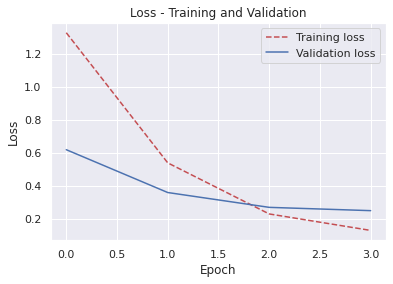


Valores Loss (promedio) obtenido en la Fase Training y Validation
-> valores Loss obtenidos recorriendo todos los batches durante las distintas épocas


In [ ]:
#import matplotlib.pyplot as plt
#% matplotlib inline
#import seaborn as sns

#CURVA DE APRENDIZAJE: 
#  Valores Loss (Promedio) obtenido en Fase Training para cada época 
#  Es decir: Loss obtenido recorriendo todos los batches durante las distintas épocas


# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = (6,4)

# Plot the learning curve.

#plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
#plt.plot ( epochs, val_acc,  'b', label='Validation acc')

plt.plot(loss_values, 'r--', label='Training loss')
plt.plot(loss_validation_values, 'b', label='Validation loss')

plt.legend()
# Label the plot.
plt.title("Loss - Training and Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show();

print("\nValores Loss (promedio) obtenido en la Fase Training y Validation")
print("-> valores Loss obtenidos recorriendo todos los batches durante las distintas épocas")

###5*.* **Evaluación: FINE-TUNING BERT**

####Preparar Datos de Prueba

1. Formato BERT: 
- Agregar tokens especiales: [CLS] y [SEP]
- Tokenizar sentencias con BertTokenizer
- Codificar tokens de BERT y Padding de sentencias
- Crear Máscaras de Atención
2. Preparar Datos para Fine-Tuning (Modo Evaluación)
- Conversión: Datos de Prueba a Tensor Torch
- Crear Iterador de Datos (DataLoader)

In [ ]:
#EVALUACIÓN SOBRE CONJUNTO TEST
# Conjunto Test: df_test['Texto'] df_test['Etiqueta']

#Datos de Test
print("EVALUACIÓN: CONJUNTO TEST")
print("\nCONJUNTO TEST CREADO:\n",df_test.head())
print("\n>>Datos a probar:",df_test.shape[0])

#Preparar datos para BERT
print("\nFORMATEAR DATOS PARA BERT:", MODEL_select)
sentencias_test = df_test["Texto"]
labels_test = df_test["Etiqueta"]

#Formatear sentencias
sentencias_test_formato = ["[CLS] "+i+" [SEP]" for i in sentencias_test]
print("\n1° sentencia formateada:\n", sentencias_test_formato[0])
#Tokenizar sentencias (texto)
# Restringir el máximo tamaño de tokens/Embedding por sentencia a 512 (MAX permitido en BERT)
tokenized_texts_test = list(map(lambda t: tokenizer.tokenize(t)[:510] , sentencias_test_formato))
print("1° sentencia tokenizada:\n", tokenized_texts_test[0])
#Mapear Tokens (texto) a Indices de BERT
input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]
#Padding y Truncate
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
print("1° sentencia Indexada + PadTrunc:\n", input_ids_test[0])
print("\n>>Cantidad de sentencias formateadas a BERT:",len(sentencias_test_formato))

# Crear attention masks para Test:
# 1:tk real | 0:tk padding
print("\nMáscaras de Atención: tks reales(1) vs tks padding(0)")
attention_masks_test = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask)
print("Máscaras de Atencion:", len(attention_masks_test))
print("Máscara de Atención asociada a la 1° sentencia:\n", attention_masks_test[0])


#CONVERSIÓN: listas a tensor pytorch
prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(labels_test)

# Setear batch_size
batch_size = BATCH_SIZE  
print("\n\nCrear iteradores (DataLoader) para Testing")
# Crear iteradores (DataLoader)
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

tamDL = len(prediction_dataloader)
print("Cantidad de Batches:", tamDL)
for i, batch in enumerate(prediction_dataloader):
  if (i<=3 or i >tamDL-4 ):
    if (i<3 or i >tamDL-4 ):
      print("Batch",i+1,"de",tamDL," - Cantidad de Sentencias:", len(batch[0]))
    if i==3: 
      print("...")

EVALUACIÓN: CONJUNTO TEST

CONJUNTO TEST CREADO:
                                                Texto  Etiqueta
0  en caso de solicitar la baja en el regimen ¿a ...         8
1  ¿en que situaciones se producira la exclusion ...         5
2  al iniciar una actividad ¿que tengo que tener ...         3
3   ¿como es el reintegro del componente impositivo?         3
4  ¿que debo hacer para que computen el pago erro...         3

>>Datos a probar: 277

FORMATEAR DATOS PARA BERT: dccuchile/bert-base-spanish-wwm-uncased

1° sentencia formateada:
 [CLS] en caso de solicitar la baja en el regimen ¿a partir de que periodo cesa la obligacion de pago? [SEP]
1° sentencia tokenizada:
 ['[CLS]', 'en', 'caso', 'de', 'solicitar', 'la', 'baja', 'en', 'el', 'reg', '##imen', '¿', 'a', 'partir', 'de', 'que', 'periodo', 'ces', '##a', 'la', 'obliga', '##cion', 'de', 'pago', '?', '[SEP]']
1° sentencia Indexada + PadTrunc:
 [    4  1035  2053  1009  9903  1032  4172  1035  1039  1363  4157  1063
  1012  3120  

####EVALUACIÓN DEL MODELO FINE-TUNING BERT 
Utilizar el modelo Fine-Tuning en modo evaluación.

Para cada batch de prueba:
1. Enviar muestras a GPU
2. Obtener datos y etiquetas del batch
3. Paso FORDWARD: Alimentar el modelo con datos de entrada y obtener predicciones
4. Obtener Logits
5. Guardar etiquetas predichas y reales



In [ ]:
#EVALUAR MODELO FINE-TUNING BERT con TESTING

print('Predecir sentencias: {} muestras'.format(len(prediction_inputs)))

# Setear el modelo en "Modo Evaluación"
model.eval()

# Variables para registrar Etiquetas Predichas y Reales
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  #1. Enviar batch a GPU
  batch = tuple(t.to(device) for t in batch)
  
  #2. Obtener datos, masks y etiquetas del batch (DataLoader)
  b_input_ids, b_input_mask, b_labels = batch
  
  
  #3. Paso Forward: Calcular prediccioens logit
  # Indicar al modelo que no calcule (ni guarde) gradientes 
  #   Esto permite guardar memoria y acelerar la Fase de Predicción
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
      
  #4. Obtener Logits  
  logits = outputs[0]

  #Mover los logits y las etiquetas a la CPU (mover de GPU a CPU)
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  #5. Guardar predicciones y etiquetas reales
  predictions.append(logits)
  true_labels.append(label_ids)

print('>>OK!')



Predecir sentencias: 277 muestras
>>OK!


###6*.* OBTENER RESULTADOS

In [ ]:
#OBTENER ACCURACY PARA CADA BATCH
#from sklearn.metrics import accuracy_score
acc_list = []
# Para cada batch (de Etiquetas Reales)
for i in range(len(true_labels)):
  #print(predictions[i])
  #Cada batch obtiene predicciones: Array de 2 columnas (0 y 1)
  #Tomar la etiqueta con el mayor valor y convertir a lista de 0 y 1 (flatten)
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  #Calcular y guardar el valor de métrica de cada batch
  val_acc = accuracy_score(true_labels[i], pred_labels_i)                
  acc_list.append(val_acc)  
print("lista de accuracy:\n",acc_list)

lista de accuracy:
 [0.8125, 0.84375, 0.90625, 0.90625, 0.9375, 0.90625, 0.90625, 0.90625, 0.8571428571428571]


MOSTRAR RESULTADOS OBTENIDOS

EVALUACIÓN FINAL
ACCURACY SCORE FINAL - CONJUNTO TEST: {} 0.888
MATRIZ DE CONFUSIÓN


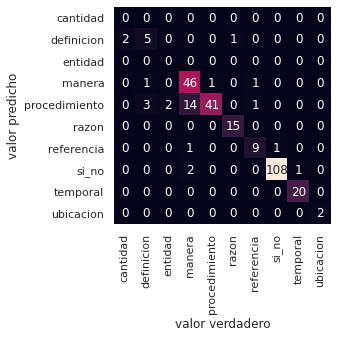

REPORTES DE CLASIFICACIÓN
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.62      0.56      0.59         9
           2       0.00      0.00      0.00         2
           3       0.94      0.73      0.82        63
           4       0.67      0.98      0.80        42
           5       1.00      0.94      0.97        16
           6       0.82      0.82      0.82        11
           7       0.97      0.99      0.98       109
           8       1.00      0.95      0.98        21
           9       1.00      1.00      1.00         2

    accuracy                           0.89       277
   macro avg       0.70      0.70      0.69       277
weighted avg       0.89      0.89      0.88       277



In [ ]:
#from sklearn.metrics import classification_report, confusion_matrix
#OBTENER DESEMPEÑO FIINAL

# Combinar predicciones de cada batch en una lista
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
#Combinar las etiquetas correctas de cada batch en una lista
flat_true_labels = [item for sublist in true_labels for item in sublist]

print("EVALUACIÓN FINAL")

#Calcular valor de métrica Accuracy
acc_final = round(accuracy_score(flat_true_labels, flat_predictions),3)

print('ACCURACY SCORE FINAL - CONJUNTO TEST: {}', acc_final)

print('MATRIZ DE CONFUSIÓN')
mat = confusion_matrix(flat_true_labels, flat_predictions)
sns.heatmap(mat.T, square=True, annot=True, cbar=False, xticklabels=np.unique(etiq_test), yticklabels=np.unique(etiq_test),fmt='d' )
plt.xlabel('valor verdadero')
plt.ylabel('valor predicho');
plt.show();

print('REPORTES DE CLASIFICACIÓN')
print(classification_report(flat_true_labels,flat_predictions))


##GUARDAR RESULTADOS

In [ ]:
# Guardar Resultados
DF_RESULTADOS = DF_RESULTADOS.append({'device': torch.cuda.get_device_name(0), 'data':DS_NAME, 'lossTrain': loss_values, 'accValid':acc_values, 'accTestFinal' :acc_final } , ignore_index=True)
DF_RESULTADOS.to_csv(FILE_NAME_RES, index=None, mode="a", header=not os.path.isfile(FILE_NAME_RES))
print("Resultados guardados en:", FILE_NAME_RES)

#Preguntas Mal Clasificadas

preds_labels_txt = revertir_etiquetas(flat_predictions)
real_labels_txt = revertir_etiquetas(flat_true_labels)

for preg, pred, real in zip(sentencias_test, preds_labels_txt, real_labels_txt):
  if pred != real:
    #print(preg, ' -CLASIFICADO COMO: ', pred, '  -DEBERIA SER: ', real,'\n') 
    global DF_MAL_CLF
    DF_MAL_CLF = DF_MAL_CLF.append({'DS': DS_NAME, 'MOD': "BERT", 'Texto': preg, 'Predicho': pred, 'Real':real}, ignore_index=True)

DF_MAL_CLF.to_csv(FILE_NAME_CLF, index=None, mode="a", header=not os.path.isfile(FILE_NAME_CLF))
print("Resultados guardados en:", FILE_NAME_CLF)

Resultados guardados en: Resultado_BETOuncased-LR5e-05-_procTest.csv
Resultados guardados en: PregMalClasif_BERT.csv


***>>FIN DE EXPERIMENTO***